In [67]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import dlc_bci as bci

from python_files.model_trainer import ModelTrainer
from python_files.history import History
from python_files.data_import import *
from python_files.nn_modules import *
from python_files.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.4.1


In [62]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

## Second NN (essayer like AlexNet)

In [63]:
data = import_data(folder='./data_bci', use_full_data = False, normalize=True)
train_input, train_target, test_input, test_target = data

train_target = (train_target*2) - 1
test_target = (test_target*2) - 1

In [64]:
class SecondConvNet(nn.Module):
    def __init__(self):
        super(SecondConvNet, self).__init__()
        self.cv1 = nn.Conv1d(28, 56, kernel_size=10)
        self.cv2 = nn.Conv1d(56, 28, kernel_size=5)
        self.cv3 = nn.Conv1d(28, 1, kernel_size=3)
        self.view = View([-1])
        self.fc1 = nn.Linear(35, 70)
        self.fc2 = nn.Linear(70, 1)
        
    def forward(self, x):
        x = F.relu(self.cv1(x))
        x = F.relu(self.cv2(x))
        x = F.relu(self.cv3(x))
        x = self.view(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.tanh(x)
        return x

In [65]:
y_hat_fun(train_target)

tensor([-1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,
        -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
         1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,
        -1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1,
        -1, -1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1,
         1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,
        -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,
         1,  1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1,  1,
         1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1, -1,
        -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,
        -1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
         1, -1,  1,  1,  1,  1,  1,  1, 

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00219           0.503         0.00694           0.490
10                      0.00216           0.570         0.00698           0.440
20                      0.00209           0.630         0.00721           0.460
30                      0.00200           0.649         0.00720           0.500
40                      0.00186           0.690         0.00743           0.460
49                      0.00174           0.747         0.00766           0.410
*******************************************************************************


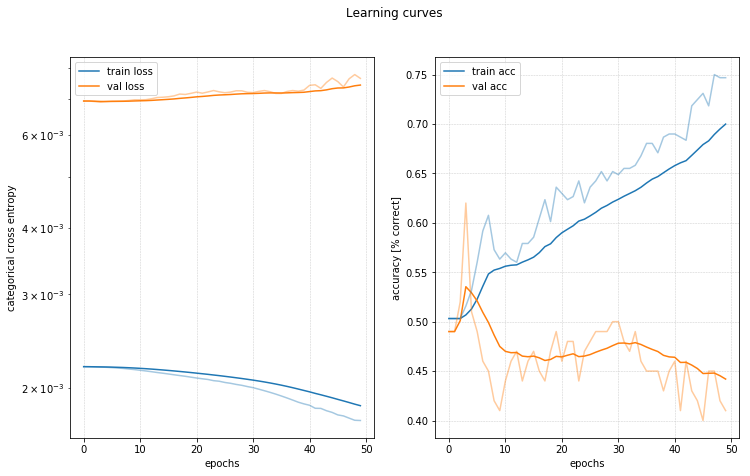

In [66]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

#model = SecondConvNet()
model = nn.Sequential(nn.Conv1d(28, 56, kernel_size=10), nn.ReLU(),
                      nn.Conv1d(56, 28, kernel_size=5), nn.ReLU(),
                      nn.Conv1d(28, 1, kernel_size=3), nn.ReLU(),
                      View([-1]),
                      nn.Linear(35, 70), nn.ReLU(),
                      nn.Linear(70, 1), nn.Tanh())

#debug_layers_dims(model, train_dataset[0].shape)

crit_fun = lambda input_, target : (input_, target.float().reshape((-1, 1)))
y_hat_fun = lambda y: ((y > 0).long()*2-1).view(-1)

mt = ModelTrainer(model, nn.SoftMarginLoss(), optim.Adam(model.parameters(), lr=0.001), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=None, verbose=10)
mt.plot_training("Learning curves")

progress: 0  1  2   done !
0 run with no learning.


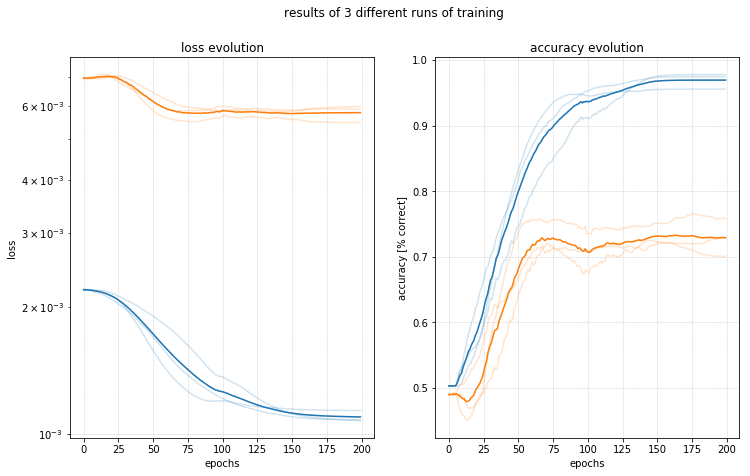

In [36]:
create_model = lambda: nn.Sequential(nn.Conv1d(28, 56, kernel_size=10), nn.ReLU(),
                                      nn.Conv1d(56, 28, kernel_size=5), nn.ReLU(),
                                      nn.Conv1d(28, 1, kernel_size=3), nn.ReLU(),
                                      View([-1]),
                                      nn.Linear(35, 70), nn.ReLU(),
                                      nn.Linear(70, 1), nn.Tanh())

crit_fun = lambda input_, target : (input_, target.float().reshape((-1, 1)))
criterion = nn.SoftMarginLoss()
optim_fun = optim.Adam
lr = 0.001
nb_epochs = 200
batch_size = None
nb_runs = 3
verbose = 0

hist_data, best_models = \
multiple_training(create_model, train_dataset, test_dataset, criterion, optim_fun, lr, crit_fun, nb_epochs, batch_size, nb_runs, verbose)

In [37]:
acc_list = []

for best_model in best_models:
    y_hat_fun=lambda y: ((y > 0).long()*2-1).view(-1).data
    y_hat = best_model(test_input)
    val_acc = (y_hat_fun(y_hat)==test_target.data).float().sum()/len(test_input)

    if (val_acc > 0.6):
        acc_list.append(val_acc)
    
print("mean val acc = ", np.mean(acc_list))
print("std of val acc = ", np.std(acc_list))

mean val acc =  0.7266667
std of val acc =  0.020548053


#### Grid search

In [6]:
def try_model(layers, kernels, mo, p, lr, batch_size, weight_decay, nb_epochs, nb_runs=1, verbose=0):
    dense_dim = (50-kernels[0]-kernels[1]+2-2-2)*(layers[1]//4)
    
    create_model = lambda:  nn.Sequential(
          nn.Conv1d(28, layers[0], kernel_size=kernels[0]), nn.ReLU(), nn.BatchNorm2d(layers[0], momentum=mo), nn.Dropout2d(p),\
          nn.Conv1d(layers[0], layers[1], kernel_size=kernels[1]), nn.ReLU(), nn.BatchNorm2d(layers[1], momentum=mo), nn.Dropout2d(p),\
          nn.Conv1d(layers[1], layers[1]//2, kernel_size=3), nn.ReLU(), nn.BatchNorm2d(layers[1]//2, momentum=mo), nn.Dropout2d(p),\
          nn.Conv1d(layers[1]//2, layers[1]//4, kernel_size=3), nn.ReLU(), nn.BatchNorm2d(layers[1]//4, momentum=mo), nn.Dropout2d(p),\
          View([-1]),\
          nn.Linear(dense_dim, dense_dim), nn.ReLU(), nn.BatchNorm1d(dense_dim, momentum=mo), nn.Dropout(p),\
          nn.Linear(dense_dim, 100), nn.ReLU(), nn.BatchNorm1d(100, momentum=mo), nn.Dropout(p),\
          nn.Linear(100, 1), nn.Tanh()
    )

    crit_fun = lambda input_, target : (input_, target.float())
    criterion = nn.SoftMarginLoss(False)
    optim_fun = lambda params, lr: optim.Adam(params, lr, weight_decay=weight_decay)


    hist_data, best_models = \
    multiple_training(create_model, train_dataset, test_dataset, criterion, optim_fun, lr, crit_fun, nb_epochs, batch_size, nb_runs, verbose, plot_figures=False)
    
    acc_list = []

    for best_model in best_models:
        y_hat_fun=lambda y: ((y > 0).long()*2-1).view(-1).data
        y_hat = best_model(te_x)
        y_hat = y_hat.view(-1, 10).mean(1)
        val_acc = (y_hat_fun(y_hat)==test_target.data).float().sum()/len(test_input)
        acc_list.append(val_acc)
    
    return np.mean(acc_list), np.std(acc_list)

In [ ]:
nb_runs = 6
verbose = 0

layers_list = [[112, 112], [56, 112], [112, 56], [168, 168]]
kernels_list = [[10, 5], [12, 8], [8, 6]]
mo_list = [1, 0.5, 0.1]
p_list = [0.5, 0.6, 0.4]
lr_list = [0.001, 0.005, 0.0001]
batch_size_list = [1*316, None]
weight_decay_list = [0.1, 1, 10]
nb_epochs_list = [200, 300, 500]


nb_search = len(layers_list)*len(kernels_list)*len(mo_list)*len(p_list)\
*len(lr_list)*len(batch_size_list)*len(weight_decay_list)*len(nb_epochs_list)
time_estimate = 30*nb_runs*nb_search

time_unit = " s"

if time_estimate > 120:
    time_estimate /= 60
    time_unit = " min"
    if time_estimate > 120:
        time_estimate /= 60
        time_unit = " hour"
        if time_estimate > 48:
            time_estimate /= 7
            time_unit = " week(s)"
    
    
print("""********************************************
estimated grid search time = {}{}
{} different combinations
********************************************\n""".format(time_estimate, time_unit, nb_search))



def grid_search():
    best_acc = 0
    best_std = 0
    best_params = ""
    i=0
    
    for layers in layers_list:
        for kernels in kernels_list:
            for mo in mo_list:
                for p in p_list:
                    for lr in lr_list:
                        for batch_size in batch_size_list:
                            for weight_decay in weight_decay_list:
                                for nb_epochs in nb_epochs_list:
                                    i += 1
                                    params_string = "parameters : layers={},kernels={},mo={},p={},lr={},batch_size={},weight_decay={},nb_epochs={},nb_runs={}"\
                                            .format(layers, kernels,mo, p, lr, batch_size, weight_decay, nb_epochs, nb_runs)
                                    print(params_string)
                                    
                                    try:
                                        acc_mean, acc_std = try_model(layers, kernels, mo, p, lr, batch_size, weight_decay, nb_epochs, nb_runs, verbose)
                                    except KeyboardInterrupt:
                                        print("\n\nINTERRUPTED\n\n")
                                        return best_acc, best_std, best_params
                                    
                                    print("\tmean val acc = ", acc_mean)
                                    print("\tstd of val acc = ", acc_std)
                                    print("\tGrid search", (i/nb_search)*100, "% done\n")
                                    
                                    if acc_mean > best_acc:
                                        best_acc = acc_mean
                                        best_std = acc_std
                                        best_params = params_string
    print("\n\n")
    return best_acc, best_std, best_params

%time best_acc, best_std, best_params = grid_search()

print("\n********************************************")
print("Best ", best_params)
print("Best acc :", best_acc)
print("Best acc std :", best_std)